<a href="https://colab.research.google.com/github/jojoclt/C/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Loading Data and importing Library

Please add the [FOLDER](https://drive.google.com/drive/folders/1nrhaTZC-0wGPOKA1ZwVdmmB2U1NqrMsJ?usp=sharing) to your root directory of Google Drive.
[paper link](https://www.researchgate.net/publication/330154837_Ripeness_Classification_of_Bananas_Using_an_Artificial_Neural_Network
)

also please join [trello](https://trello.com/b/uPv9MgUv/ml-proj-banana)

Data arr; dataset, dataset_label

data_processed

data_segmented

In [2]:
#TO RUN
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#TO RUN
import sys
import os
# sys.path.append('/content/drive/MyDrive/Project/')
if (os.getcwd() == '/content'): 
    os.chdir('./drive/MyDrive/Project')

In [4]:
#TO RUN
import os
import math
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#image filter
from skimage import filters, color
from skimage.color import hsv2rgb
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from skimage.color import gray2rgb

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import cv2

from itertools import repeat
from collections import Counter

# 1. Inputting Data

In [5]:
#TO RUN: load dataset
PATH='Fayoum_University_Banana _Classes'
folder_name = os.listdir(PATH)
dataset = []

# Green 104 Midripen 88 Overripen 33 Yellowish_green 48
data_keys = ('g','m','v','y')
dataset_label = []

for name in sorted(folder_name):
    subfolder = os.path.join(PATH, name)
    for fh in sorted(os.listdir(subfolder)):
        file_name = os.path.join(subfolder,fh)
        img = cv2.imread(file_name, cv2.IMREAD_COLOR)
        dataset.append(img)
        dataset_label.append(data_keys.index(fh[0]))

# 2. Image Preprocessing

Also, cv2 input will be in bgr instead of rgb, use bgr2rgb function helper to convert it, then use plt to plot

Gonna Find the highest occurences of shapes, then reshape to the most occuring shape.

In [6]:
c = Counter([ele.shape for ele in dataset])
c

Counter({(540, 960, 3): 118,
         (1072, 1920, 3): 1,
         (536, 960, 3): 153,
         (636, 960, 3): 1})

In [79]:
#TO RUN: def function for preprocessing image
ker = 5
r = 3
eps = 0.05

# cv2 width height reversed https://stackoverflow.com/a/22094421
IMG_SIZE = (960,536)

def process_image(img, ker=ker, r=r, eps=eps):
    # Step 0: Resize Image
    img = cv2.resize(img.astype(np.uint8), IMG_SIZE)

    # Step 1: Applying Guided Filter to preserve edges and smoothing on img
    # https://blog.csdn.net/youcans/article/details/122008763
    img = cv2.ximgproc.guidedFilter(img, img, r, eps)
    
    # Step 2: convert BGR to HSV
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Step 3: Morphological Filtering 
    # https://towardsdatascience.com/image-processing-class-egbe443-6-morphological-filter-e952c1ec886e
    kernel = np.ones((ker, ker), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)
    # img = cv2.erode(img, kernel, iterations=2)
    # img = cv2.dilate(img, kernel, iterations=5)

    return img

In [8]:
# BGR
data_processed = np.array(list(map(process_image, dataset)))

In [9]:
c = Counter([ele.shape for ele in data_processed])
c

Counter({(536, 960, 3): 273})

#3. Fruit Segmentation


## Helper Func

Both cv2 and skimg segment works, but use skimg instead

In [10]:
def hsv2gray(img):
    return rgb2gray(hsv2rgb(img))
def gray2hsv(img):
    return rgb2hsv(gray2rgb(img))
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def gray2bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
def bgr2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [11]:
def HSV_to_cv(h,s,v):
    return (h/2, s/100 * 255, v/100 * 255)

### Hidden cv2

In [12]:
def show_intensity_histogram(image):
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.hist(image_grayscale.ravel(), 256)
    plt.title('Intensity histogram')
    plt.ylabel('Number of pixels')
    plt.xlabel('Light intensity')
    plt.show()

In [13]:
# also works, but use skimage filter instead
# https://stackoverflow.com/questions/59235904/how-to-remove-shadows-from-foreground-after-segmentation
def show_mask(mask, image, title='', mask_color=(0, 0, 0)):
    display_image = image.copy()
    display_image[mask != 0] = mask_color
    plt.imshow(display_image)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def compute_otsu_mask(image):
  image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return cv2.threshold(image_grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


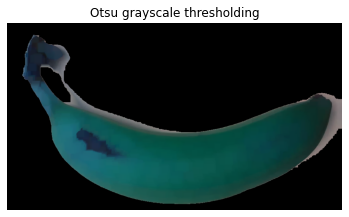

In [14]:
# l = np.random.randint(0,272)
# print(l)
c = process_image(dataset[64],eps=0.01,r=5)
mask_otsu = compute_otsu_mask(c)
show_mask(mask_otsu, c, title='Otsu grayscale thresholding')

## Banana Segmented

In [15]:
def segmentation_mask_skimg(img):
    image = bgr2gray(img)
    thresh = filters.threshold_otsu(image)
    mask = (image <= thresh).astype(int)
    return mask
def segment_image_skimg(img):
    mask = segmentation_mask_skimg(img)
    masked = np.zeros_like(img)
    for i in range(3): 
        masked[:,:,i] = np.where(mask, img[:,:,i], 0)
    return masked

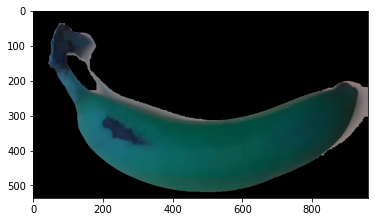

In [16]:
img = data_processed[64]
v = segment_image_skimg(img)
plt.imshow(v)

In [17]:
def remove_shadow(image):
    # (hMin = 0 , sMin = 60, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
    blank_mask = np.zeros_like(image)
    original = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 60, 0])
    upper = np.array([179, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        cv2.drawContours(blank_mask,[c], -1, (255,255,255), -1)
        break

    result = cv2.bitwise_and(original,blank_mask)
    return result

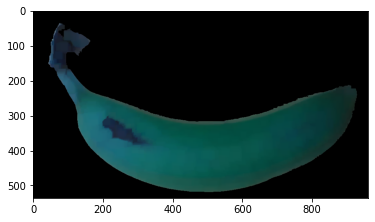

In [18]:
plt.imshow(remove_shadow(v))

In [19]:
def segment_image(img):
    return remove_shadow(segment_image_skimg(img))

In [20]:
data_segmented = np.array(list(map(segment_image, data_processed)))

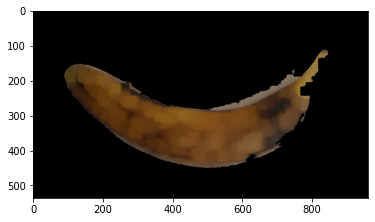

In [54]:
# Tester Here # some pic might looks bad cause the remove_shadow part does not apply to all banana, but it is usable...
rand = np.random.randint(0,274)
plt.imshow(bgr2rgb(data_segmented[215]))

In [ ]:
def segment_spots(img):
    # https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv
    # HSV Inconsistencies

    # Normal H = 0-360, S = 0-100 and V = 0-100. 
    # But OpenCV uses H: 0-179, S: 0-255, V: 0-255.
    # (H/2, (S/100) * 255, (V/100) * 255) 
    lower_bound = HSV_to_cv(30, 66, 4.7)
    upper_bound = HSV_to_cv(30, 67.6, 60)

    # Create the mask using cv2.inRange()
    mask = cv2.inRange(img, lower_bound, upper_bound)

    # # Apply the mask to the original image using cv2.bitwise_and()
    # result = cv2.bitwise_and(hsv2rgb(img), hsv2rgb(img), mask=mask)
    return mask

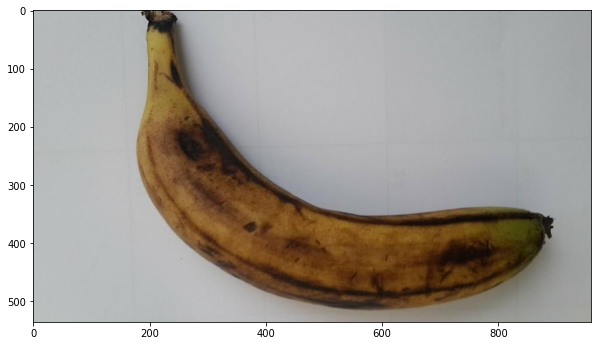

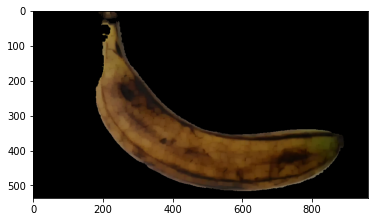

In [80]:
plt.figure(figsize=(10,10))
val = 222
plt.imshow(bgr2rgb(dataset[val]))
plt.show()
aaa=process_image(dataset[val],eps=0.05,r=10)

plt.imshow(segment_image(bgr2rgb(aaa)))
plt.show()

#4. Extracting Fruit Features

ref: https://github.com/MarshalLeeeeee/Tamura-In-Python
https://stackoverflow.com/questions/28421167/tamuras-coarseness-textural-feature


#5. Data Augmentation

In [ ]:
# https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    #tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

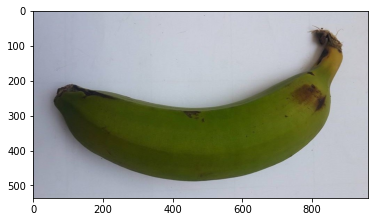

In [ ]:
idx = np.random.randint(0, 273)
image = cv2.cvtColor(dataset[idx], cv2.COLOR_BGR2RGB)
plt.imshow(image)

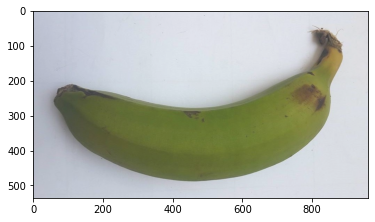

In [ ]:
augmented_image = data_augmentation(image).numpy().astype(int)
plt.imshow(augmented_image)


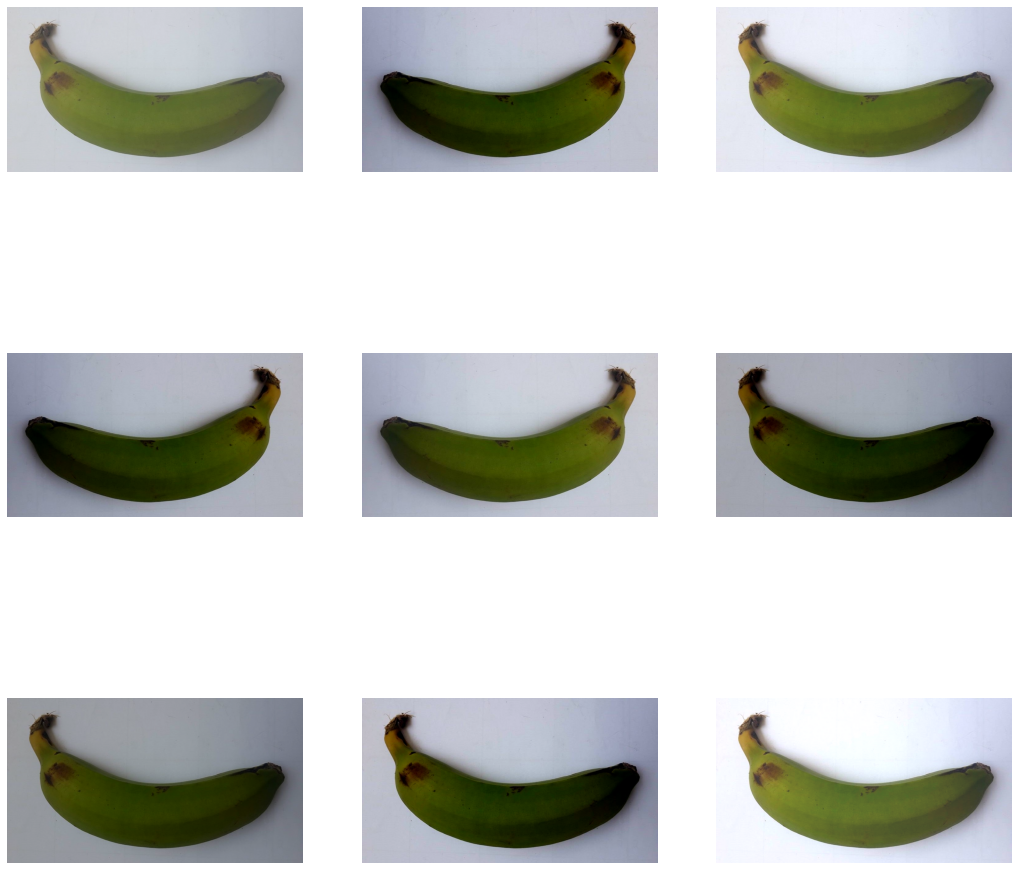

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(9):
    augmented_image = data_augmentation(image).numpy().astype(int)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")

#6. Model